In [2]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy

In [3]:
import sys
sys.path.append("../filtering/")

%load_ext autoreload
%autoreload 2

In [4]:
import example_systems

pendulum_system_gt = example_systems.generate_pendulum_system()

In [5]:
from helpers import vec

timesteps = np.arange(0.0, 25.0, step=pendulum_system_gt.delta_t)
T = len(timesteps)

states_gt = np.zeros((T, 6, 1))
controls = np.zeros((T, 1, 1))
measurements = np.zeros((T, 2, 1))

# initial position and velocity
states_gt[0] = vec(
    0,              # cart
    np.pi,          # theta_1
    np.pi,          # theta_2
    0,              # cart_vel
    0,              # theta_1_vel
    0               # theta_2_vel
)

# cart acceleration schedule
t = np.min(np.argwhere(timesteps > 1.0))
controls[t:2*t] = vec(50.0)
controls[3*t:4*t] = vec(-50.0)

for t in tqdm(range(1, T)):
    x = states_gt[t-1]
    u = controls[t]

    x_next = pendulum_system_gt.query_dynamics_model(x, u)
    states_gt[t] = x_next

    z = pendulum_system_gt.query_measurement_model(x_next)
    measurements[t] = z


100%|██████████| 24999/24999 [00:08<00:00, 2901.09it/s]


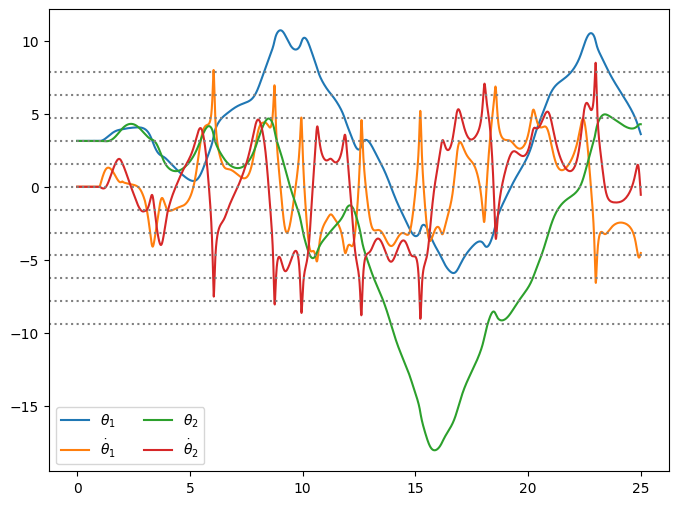

In [6]:
t_max = np.max(np.argwhere(~np.isnan(states_gt[:,4,0])))

if t_max < T-1:
    print("WARNING: System diverges at around t =", t_max)
    t_max -= 10

cart_gt = states_gt[:t_max,0,0]
cart_vel_gt = states_gt[:t_max,3,0]
theta_1_gt = states_gt[:t_max,1,0]
theta_1_vel_gt = states_gt[:t_max,4,0]
theta_2_gt = states_gt[:t_max,2,0]
theta_2_vel_gt = states_gt[:t_max,5,0]

fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(timesteps[:t_max], cart_gt, label="cart")
# ax.plot(timesteps[:t_max], cart_vel_gt, label="cart_vel")
ax.plot(timesteps[:t_max], theta_1_gt, label=r"$\theta_1$")
ax.plot(timesteps[:t_max], theta_1_vel_gt, label=r"$\dot\theta_1$")
ax.plot(timesteps[:t_max], theta_2_gt, label=r"$\theta_2$")
ax.plot(timesteps[:t_max], theta_2_vel_gt, label=r"$\dot\theta_2$")
for y in np.arange(-3*np.pi, 3*np.pi, step=np.pi/2):
    ax.axhline(y, 0, timesteps[t_max], linestyle=":", color="gray")

ax.legend(ncol=2)

In [7]:
# Test all filters on same system model approximation
subsample = 10            # filters run at a fraction of sampling rate of the simulation
timesteps_sub = timesteps[::subsample]
states_gt_sub = states_gt[::subsample]
measurements_sub = measurements[::subsample]
controls_sub = controls[::subsample]
T_sub = len(timesteps_sub)

pendulum_system_approx = example_systems.generate_pendulum_system(dt=pendulum_system_gt.delta_t * subsample)

In [8]:
# Test all filters with the same initial belief
initial_covariance = np.diag([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3])
initial_mean = np.random.multivariate_normal(states_gt[0,:,0], initial_covariance).reshape(-1, 1)

initial_state_estimate = (initial_mean, initial_covariance)
initial_state_estimate

(array([[-0.01955892],
        [ 3.14575638],
        [ 3.12449409],
        [ 0.0111587 ],
        [-0.0189668 ],
        [ 0.01582478]]),
 array([[0.001, 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.001, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.001, 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.001, 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.001, 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.001]]))

In [9]:
def plot_filter_results(means, filter_name):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True)
    fig.suptitle(f"Filtering Results: {filter_name}")

    ax1.set_xlabel("time")
    ax1.plot(timesteps_sub, states_gt_sub[:,0,0], label=r"$x$", color="tab:blue")
    ax1.plot(timesteps_sub, states_gt_sub[:,1,0], label=r"$\theta_1$", color="tab:orange")
    ax1.plot(timesteps_sub, states_gt_sub[:,2,0], label=r"$\theta_2$", color="tab:red")
    ax1.plot(timesteps_sub, means[:,0,0], label=rf"$x$ ({filter_name})", color="tab:blue", linestyle="--")
    ax1.plot(timesteps_sub, means[:,1,0], label=rf"$\theta_1$ ({filter_name})", color="tab:orange", linestyle="--")
    ax1.plot(timesteps_sub, means[:,2,0], label=rf"$\theta_2$ ({filter_name})", color="tab:red", linestyle="--")

    for y in np.arange(-2*np.pi, 3*np.pi, step=np.pi/2):
        ax1.axhline(y, linestyle=":", color="gray")

    ax1.legend(ncol=2)

    ax2.set_xlabel("time")
    ax2.plot(timesteps_sub, states_gt_sub[:,3,0], label=r"$\dot x$", color="tab:blue")
    ax2.plot(timesteps_sub, states_gt_sub[:,4,0], label=r"$\dot\theta_1$", color="tab:orange")
    ax2.plot(timesteps_sub, states_gt_sub[:,5,0], label=r"$\dot\theta_2$", color="tab:red")
    ax2.plot(timesteps_sub, means[:,3,0], label=rf"$\dot x$ ({filter_name})", color="tab:blue", linestyle="--")
    ax2.plot(timesteps_sub, means[:,4,0], label=rf"$\dot\theta_1$ ({filter_name})", color="tab:orange", linestyle="--")
    ax2.plot(timesteps_sub, means[:,5,0], label=rf"$\dot\theta_2$ ({filter_name})", color="tab:red", linestyle="--")

    for y in np.arange(-2*np.pi, 3*np.pi, step=np.pi/2):
        ax2.axhline(y, linestyle=":", color="gray")

    ax2.legend(ncol=2)

100%|██████████| 2499/2499 [00:11<00:00, 217.76it/s]


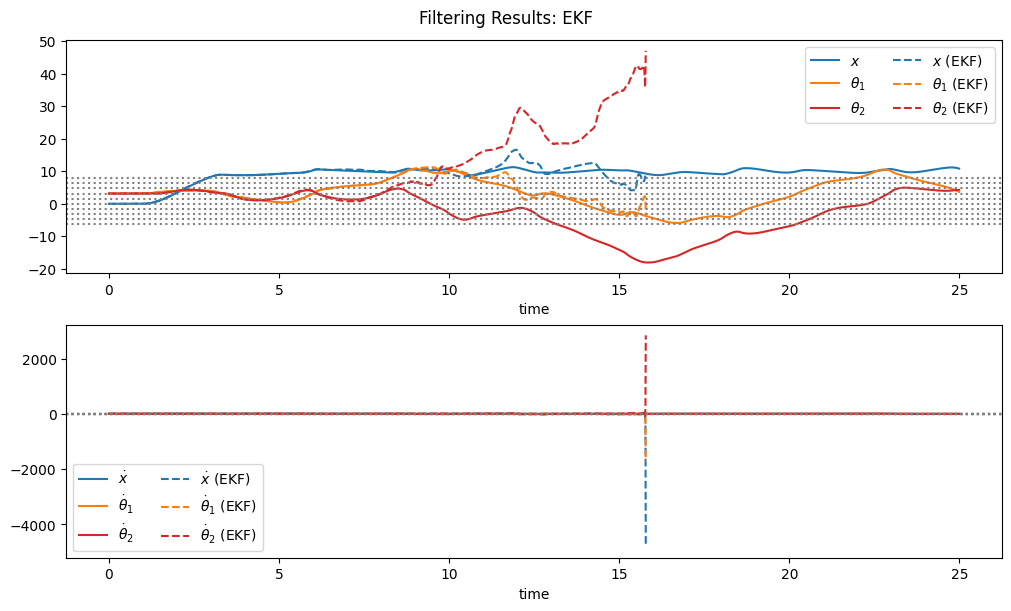

In [10]:
# Run the EKF

from filters import ExtendedKalmanFilter
pendulum_EKF = ExtendedKalmanFilter(pendulum_system_approx)

# initial state belief
pendulum_EKF.initialize(*initial_state_estimate)

means_EKF = np.zeros((T_sub, 6, 1))
covariances_EKF = np.zeros((T_sub, 6, 6))

means_EKF[0] = pendulum_EKF.mean
covariances_EKF[0] = pendulum_EKF.covariance

for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    pendulum_EKF.predict_step(u)
    pendulum_EKF.update_step(z)

    means_EKF[t] = pendulum_EKF.mean
    covariances_EKF[t] = pendulum_EKF.covariance

# Plot results
plot_filter_results(means_EKF, "EKF")

100%|██████████| 2499/2499 [00:05<00:00, 429.70it/s]


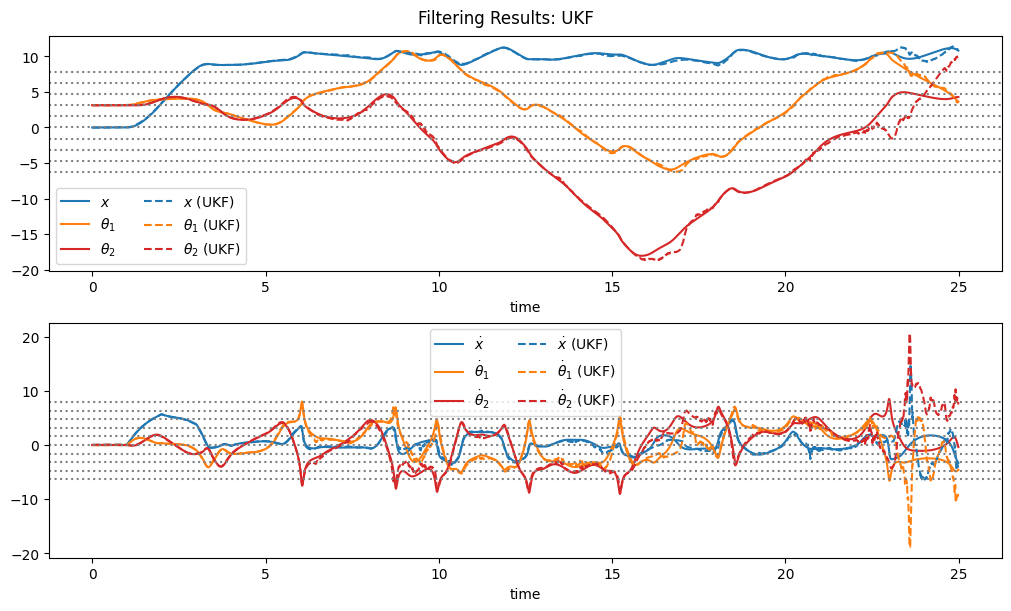

In [11]:
# Run the UKF

from filters import UnscentedKalmanFilter
pendulum_UKF = UnscentedKalmanFilter(pendulum_system_approx)

# initial state belief
pendulum_UKF.initialize(*initial_state_estimate)

means_UKF = np.zeros((T_sub, 6, 1))
covariances_UKF = np.zeros((T_sub, 6, 6))

means_UKF[0] = pendulum_UKF.mean
covariances_UKF[0] = pendulum_UKF.covariance


for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    pendulum_UKF.predict_step(u)
    pendulum_UKF.update_step(z)

    means_UKF[t] = pendulum_UKF.mean
    covariances_UKF[t] = pendulum_UKF.covariance


# Plot results
plot_filter_results(means_UKF, "UKF")

100%|██████████| 2499/2499 [00:14<00:00, 170.05it/s]


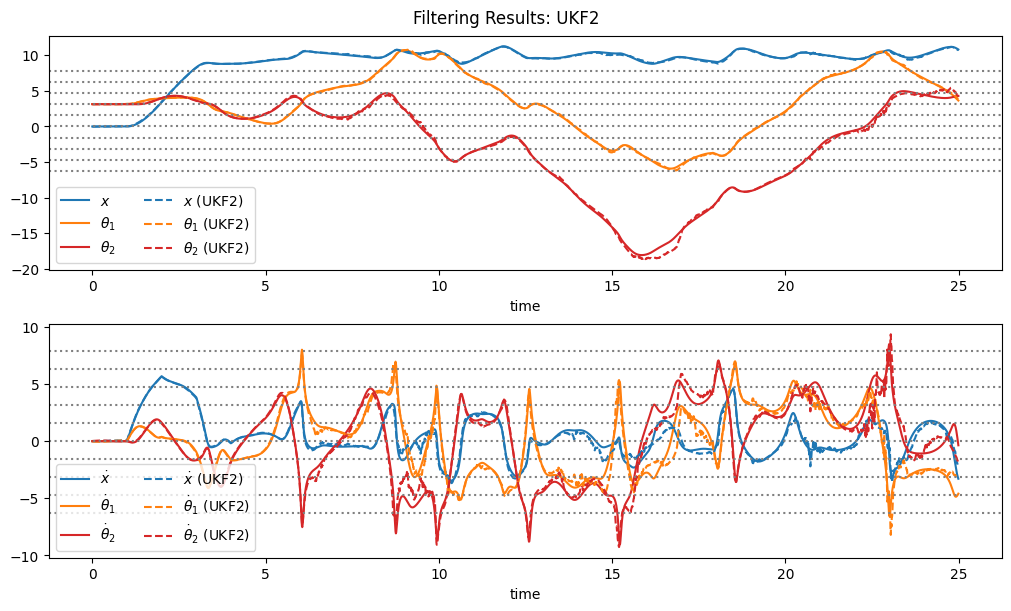

In [21]:
# Run the UKF Variant

from probability.sigma_points import MultiShellSigmaPointSelector

pendulum_UKF2 = UnscentedKalmanFilter(
    pendulum_system_approx,
    sigma_point_selector=MultiShellSigmaPointSelector([0.2, 0.4, 0.8])
)

# initial state belief
pendulum_UKF2.initialize(*initial_state_estimate)

means_UKF2 = np.zeros((T_sub, 6, 1))
covariances_UKF2 = np.zeros((T_sub, 6, 6))

means_UKF2[0] = pendulum_UKF2.mean
covariances_UKF2[0] = pendulum_UKF2.covariance


for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    pendulum_UKF2.predict_step(u)
    pendulum_UKF2.update_step(z)

    means_UKF2[t] = pendulum_UKF2.mean
    covariances_UKF2[t] = pendulum_UKF2.covariance


# Plot results
plot_filter_results(means_UKF2, "UKF2")

In [22]:
# Error Analysis

errors_EKF = means_EKF - states_gt_sub
errors_UKF = means_UKF - states_gt_sub
errors_UKF2 = means_UKF2 - states_gt_sub

print("EKF Error: ", np.mean(np.linalg.norm(errors_EKF, axis=1)))
print("UKF Error: ", np.mean(np.linalg.norm(errors_UKF, axis=1)))
print("UKF2 Error:", np.mean(np.linalg.norm(errors_UKF2, axis=1)))

EKF Error:  nan
UKF Error:  1.6892940781085777
UKF2 Error: 0.7476320973593871


In [24]:
from animate_pendulum import animate_pendulum

plt.rcParams["animation.html"] = "jshtml"

fig, ax = plt.subplots(figsize=(8,6))
ani = animate_pendulum(
    fig, ax,
    timesteps_sub,
    [states_gt_sub, means_EKF, means_UKF, means_UKF2],
    controls_sub,
    2.0, 3.0,
    colors=[("tab:gray", "tab:gray"), ("tab:gray", "tab:blue"), ("tab:gray", "tab:orange"), ("tab:gray", "tab:green")],
    alphas=[1.0, 0.5, 0.5, 0.5],
    labels=["ground truth", "EKF estimate", "UKF estimate", "UKF2 estimate"],
    subsample=10
)
# ani
ani.save("../../figures/double_pendulum_EKF_vs_UKF_vs_UKF2.mp4")

FPS: 10
0/250
100/250
200/250
250/250
